In [1]:
pip install tensorflow


In [2]:
!pip install keras-tuner --upgrade


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner as kt

# **Predicting Sessions Per Hour (With Neural Network)**


In [4]:


# Load & clean
df = pd.read_csv("energydata_with_cost.csv")
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df = df[df["chargedEnergyKwh"] > 0].copy()

# Hourly sessions
df.set_index("chargingStartTime", inplace=True)
hourly_counts = df.resample("H").size().rename("sessions")
hourly_counts = hourly_counts.asfreq("H", fill_value=0)

# Create features
WINDOW = 24
X, y = [], []
vals = hourly_counts.values
for i in range(len(vals) - WINDOW):
    X.append(vals[i:i + WINDOW])
    y.append(vals[i + WINDOW])
X = np.array(X)
y = np.array(y)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build model function
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=256, step=32),
                    activation=hp.Choice('act1', ['relu', 'tanh']),
                    input_shape=(X_train.shape[1],)))
    if hp.Boolean('dropout1'):
        model.add(Dropout(rate=hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=128, step=16),
                    activation=hp.Choice('act2', ['relu', 'tanh'])))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(
                      hp.Float("lr", 1e-4, 1e-2, sampling="log")),
                  loss='mse', metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(build_model,
                        objective='val_mae',
                        max_trials=3,
                        executions_per_trial=1,
                        overwrite=True,
                        directory='tuning_dir',
                        project_name='charging_forecast')

tuner.search(X_train, y_train, validation_split=0.2, epochs=50, verbose=1)

# Best model
best_model = tuner.get_best_models(num_models=1)[0]
y_pred = best_model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R²-score on test set: {r2:.3f}")


Trial 3 Complete [00h 00m 24s]
val_mae: 4.2706170082092285

Best val_mae So Far: 4.249109745025635
Total elapsed time: 00h 01m 26s
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


R²-score on test set: 0.819


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


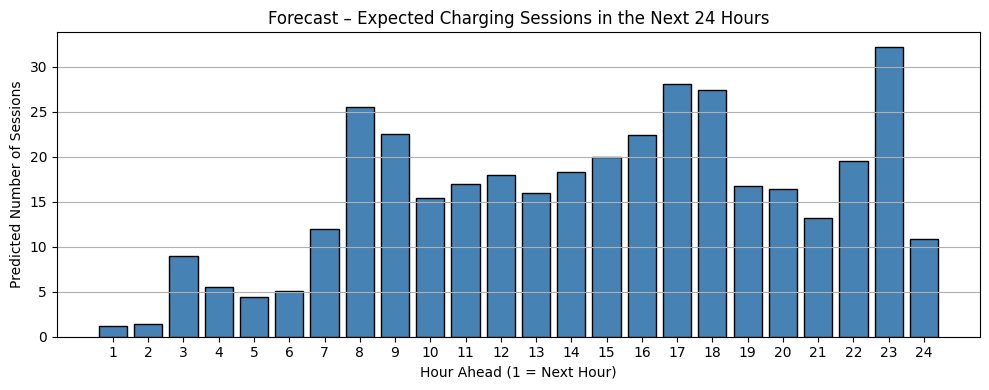

✅ CSV saved as predicted_sessions.csv


In [6]:
import matplotlib.pyplot as plt

# Forecast the next 24 hours
raw_window = hourly_counts.values[-WINDOW:].copy()
forecast = []

for _ in range(24):
    # Scale the current window
    win_scaled = scaler.transform(raw_window.reshape(1, -1))
    pred = best_model.predict(win_scaled)[0, 0]
    forecast.append(pred)
    # Update the window with the predicted value
    raw_window = np.roll(raw_window, -1)
    raw_window[-1] = pred

# Display the bar chart
plt.figure(figsize=(10, 4))
plt.bar(range(1, 25), forecast, color="steelblue", edgecolor="k")
plt.title("Forecast – Expected Charging Sessions in the Next 24 Hours")
plt.xlabel("Hour Ahead (1 = Next Hour)")
plt.ylabel("Predicted Number of Sessions")
plt.xticks(range(1, 25))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Save forecast to CSV
sessions_df = pd.DataFrame({"hour_ahead": range(1, 25), "predicted_sessions": forecast})
sessions_df.to_csv("predicted_sessions.csv", index=False)
print("✅ CSV saved as predicted_sessions.csv")


# **Predicting Prices Per Kwh Per Hour (With Neural Network)**

Trial 2 Complete [00h 01m 59s]
val_loss: 0.0006314723868854344

Best val_loss So Far: 0.0006314723868854344
Total elapsed time: 00h 03m 53s
 39/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MAE  : 0.0190 €/kWh
Test RMSE : 0.0252 €/kWh
Test R²   : 0.610
  91/1426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1426/1426 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


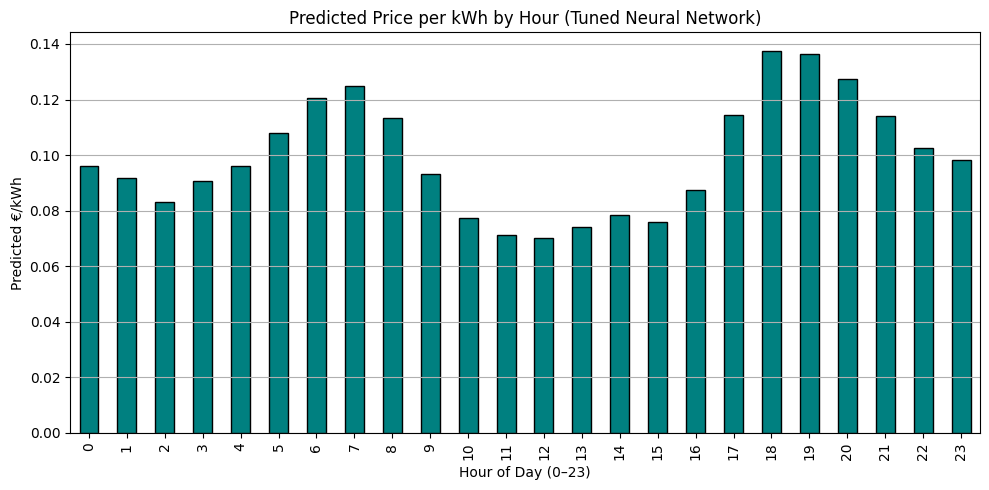

✅ CSV saved as predicted_prices.csv


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

# 1. Load & prepare data
df = pd.read_csv("energydata_with_cost.csv")
df = df[(df.chargedEnergyKwh > 0) & (df.estimatedCostEUR > 0)].copy()
df["price_per_kwh"] = df.estimatedCostEUR / df.chargedEnergyKwh

# Filter outliers
q_low = df["price_per_kwh"].quantile(0.01)
q_high = df["price_per_kwh"].quantile(0.99)
df = df[(df["price_per_kwh"] >= q_low) & (df["price_per_kwh"] <= q_high)]

# Time features
df["chargingStartTime"] = pd.to_datetime(df["chargingStartTime"], errors="coerce")
df = df.dropna(subset=["chargingStartTime"])
df["hour"] = df.chargingStartTime.dt.hour
df["weekday"] = df.chargingStartTime.dt.weekday
df["month"] = df.chargingStartTime.dt.month
df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])
df["hour_sin"] = np.sin(2 * np.pi * df.hour / 24)
df["hour_cos"] = np.cos(2 * np.pi * df.hour / 24)
df["weekday_sin"] = np.sin(2 * np.pi * df.weekday / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df.weekday / 7)

month_dummies = pd.get_dummies(df.month, prefix="month", drop_first=True)
df = pd.concat([df, month_dummies], axis=1)

# Features
feature_cols = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "chargedEnergyKwh_log"
] + list(month_dummies.columns)
X = df[feature_cols].values
y = df["price_per_kwh"].values

# Split & scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# 2. Define model for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_s.shape[1],)))

    # Hidden layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh", "elu"])
        ))
        model.add(tf.keras.layers.Dropout(
            rate=hp.Float(f"dropout_{i}", 0.0, 0.5, step=0.1)
        ))

    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

# 3. Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=2,
    overwrite=True,
    directory="tuner_dir",
    project_name="price_prediction"
)

# 4. Run tuning
tuner.search(X_train_s, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

# 5. Best model
best_model = tuner.get_best_models(num_models=1)[0]

# 6. Evaluate
y_pred = best_model.predict(X_test_s).flatten()
print(f"Test MAE  : {mean_absolute_error(y_test, y_pred):.4f} €/kWh")
print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f} €/kWh")
print(f"Test R²   : {r2_score(y_test, y_pred):.3f}")

# 7. Plot predictions per hour
df["predicted_price_per_kwh"] = best_model.predict(scaler.transform(df[feature_cols])).flatten()
hourly_profile = df.groupby("hour")["predicted_price_per_kwh"].mean().reindex(range(24))

plt.figure(figsize=(10, 5))
hourly_profile.plot(kind="bar", color="teal", edgecolor="k")
plt.title("Predicted Price per kWh by Hour (Tuned Neural Network)")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Predicted €/kWh")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

price_df = pd.DataFrame({
    "hour": hourly_profile.index,
    "predicted_price_per_kwh": hourly_profile.values
})
price_df.to_csv("predicted_prices.csv", index=False)
print("✅ CSV saved as predicted_prices.csv")

# **Predicting Energy Consumption Per Hour (With Neural Network)**


Trial 2 Complete [00h 00m 36s]
val_loss: 449151.71875

Best val_loss So Far: 307775.71875
Total elapsed time: 00h 00m 48s
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test MAE  : 430.10 kWh
Test RMSE : 607.59 kWh
Test R²   : 0.851


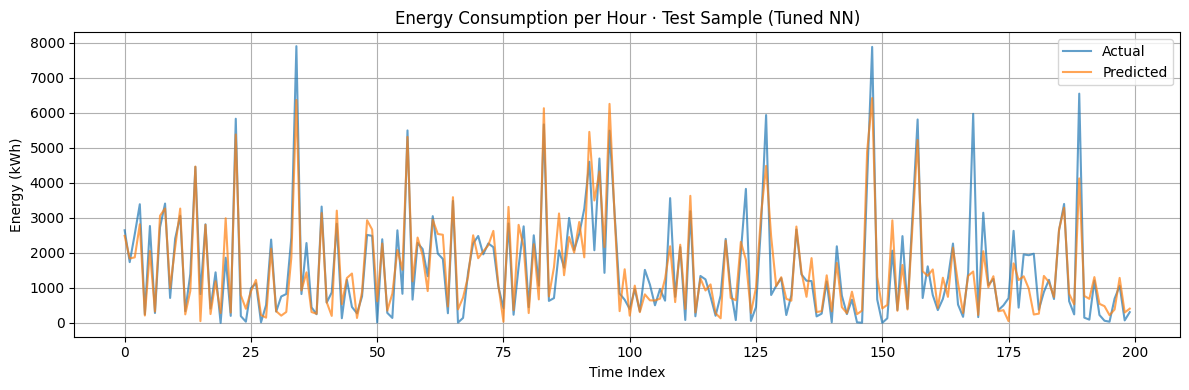

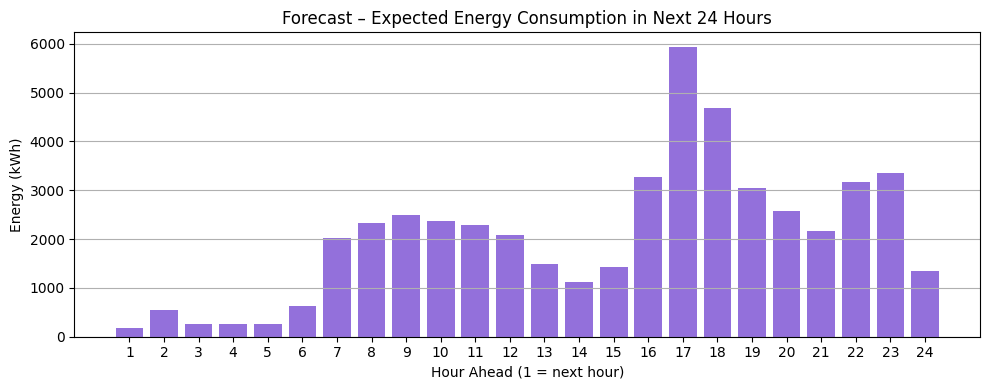

✅ CSV saved as predicted_energy_consumption.csv


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# 1. Load & preprocess
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["chargingStartTime"])
df = df[df["chargedEnergyKwh"] > 0].copy()

df["hour_of_day"] = df["chargingStartTime"].dt.floor("H")
hourly = (
    df.groupby("hour_of_day")["chargedEnergyKwh"]
      .sum()
      .rename("energy_kwh")
      .reset_index()
)

# 2. Time-features
hourly["hour"]       = hourly["hour_of_day"].dt.hour
hourly["weekday"]    = hourly["hour_of_day"].dt.weekday
hourly["is_weekend"] = (hourly["weekday"] >= 5).astype(int)

# 3. Supervised dataset (24 lags)
WINDOW = 24
rows = []
for i in range(WINDOW, len(hourly)):
    lags       = hourly["energy_kwh"].values[i-WINDOW:i]
    time_feats = hourly.loc[i, ["hour", "weekday", "is_weekend"]].values
    target     = hourly.loc[i, "energy_kwh"]
    rows.append(np.hstack([lags, time_feats, target]))

cols = [f"lag_{j}" for j in range(WINDOW, 0, -1)] + ["hour", "weekday", "is_weekend", "target"]
sup_df = pd.DataFrame(rows, columns=cols)

# 4. Train/test split
X = sup_df.drop("target", axis=1).values.astype("float32")
y = sup_df["target"].values.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# 5. Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 6. Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int("units_1", 32, 256, step=32),
        activation=hp.Choice("activation_1", ["relu", "tanh"]),
        input_shape=(X_train_s.shape[1],)
    ))
    for i in range(hp.Int("n_layers", 1, 3)):
        model.add(Dense(
            units=hp.Int(f"units_{i+2}", 16, 128, step=16),
            activation=hp.Choice(f"activation_{i+2}", ["relu", "tanh"])
        ))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse"
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_energy",
    project_name="forecast_energy"
)

tuner.search(X_train_s, y_train,
             validation_split=0.1,
             epochs=100,
             batch_size=32,
             callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

# 7. Evaluate
y_pred = best_model.predict(X_test_s).flatten()
print(f"Test MAE  : {mean_absolute_error(y_test, y_pred):.2f} kWh")
print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} kWh")
print(f"Test R²   : {r2_score(y_test, y_pred):.3f}")

plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.title("Energy Consumption per Hour · Test Sample (Tuned NN)")
plt.xlabel("Time Index")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Forecast next 24 hours
last_window = hourly["energy_kwh"].values[-WINDOW:].tolist()
forecast = []
for step in range(1, 25):
    next_hour_dt = hourly["hour_of_day"].iloc[-1] + pd.Timedelta(hours=step)
    h, wd = next_hour_dt.hour, next_hour_dt.weekday()
    is_we = int(wd >= 5)
    features = np.hstack([last_window[-WINDOW:], [h, wd, is_we]])
    pred = best_model.predict(scaler.transform(features.reshape(1, -1)), verbose=0)[0,0]
    forecast.append((step, pred))
    last_window.append(pred)

forecast_df = pd.DataFrame(forecast, columns=["hour_ahead", "predicted_energy_kwh"])

# 9. Plot forecast
plt.figure(figsize=(10,4))
plt.bar(forecast_df["hour_ahead"], forecast_df["predicted_energy_kwh"],
        color="mediumpurple")
plt.title("Forecast – Expected Energy Consumption in Next 24 Hours")
plt.xlabel("Hour Ahead (1 = next hour)")
plt.ylabel("Energy (kWh)")
plt.xticks(range(1, 25))
plt.grid(axis="y")
plt.tight_layout()
plt.show()

forecast_df.to_csv("predicted_energy_consumption.csv", index=False)
print("✅ CSV saved as predicted_energy_consumption.csv")

# **Average Departure Delay**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4933.6177 - val_loss: 1615.7150 - learning_rate: 0.0010
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1641.2684 - val_loss: 1606.0454 - learning_rate: 0.0010
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1649.1877 - val_loss: 1587.9392 - learning_rate: 0.0010
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1667.6808 - val_loss: 1591.8832 - learning_rate: 0.0010
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1612.2268 - val_loss: 1575.6971 - learning_rate: 0.0010
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1567.0142 - val_loss: 1589.3566 - learning_rate: 0.0010
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1631.5388 - val_loss: 1571.6621 - learning_rate: 0.0010
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1608.5349 - val_loss: 1566.9847 - learning_rate: 0.0010
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1533.4834 - val

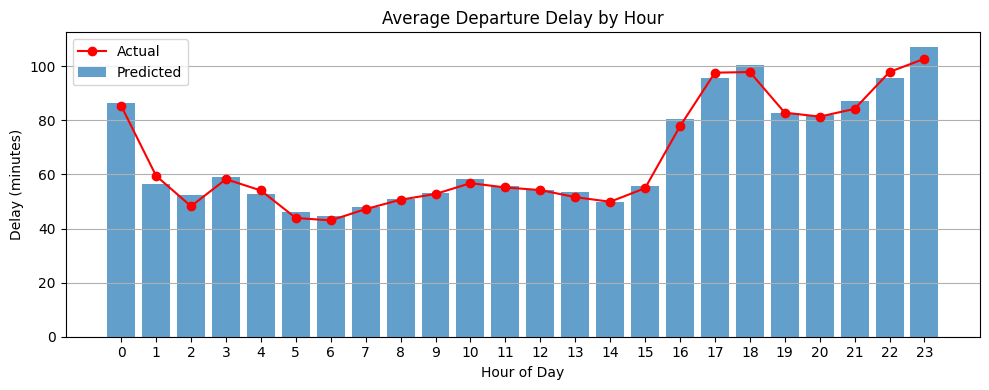

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ──────────────────────────────
# 1. Load & preprocess
# ──────────────────────────────
df = pd.read_csv("energydata_with_cost.csv", parse_dates=["chargingStartTime", "chargingEndTime"])
df = df[df["chargedEnergyKwh"] > 0].copy()
df["departure_delay_minutes"] = (df["chargingEndTime"] - df["chargingStartTime"]).dt.total_seconds() / 60
df = df[df["departure_delay_minutes"] <= 480]

# Time features
df["hour"] = df["chargingStartTime"].dt.hour
df["weekday"] = df["chargingStartTime"].dt.weekday
df["is_weekend"] = (df["weekday"] >= 5).astype(int)
df["dayofyear"] = df["chargingStartTime"].dt.dayofyear
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

# Energy features
df["chargedEnergyKwh_log"] = np.log1p(df["chargedEnergyKwh"])

# Shift indicators
df["shift_start_morning"] = df["hour"].between(7, 9).astype(int)
df["shift_end_evening"] = df["hour"].between(16, 18).astype(int)
df["weekend_and_shift"] = df["shift_start_morning"] * df["is_weekend"]

# Categorical bins
df["start_hour_bin"] = pd.cut(df["hour"], bins=[0, 6, 10, 16, 21, 24],
                              labels=["Night", "Morning", "Afternoon", "Evening", "Late"], right=False)

# One-hot encoding
weekday_dummies = pd.get_dummies(df["weekday"], prefix="wd", drop_first=True)
period_dummies = pd.get_dummies(df["start_hour_bin"], prefix="period", drop_first=True)
df = pd.concat([df, weekday_dummies, period_dummies], axis=1)

# ──────────────────────────────
# 2. Feature set
# ──────────────────────────────
feature_cols = [
    "hour_sin", "hour_cos", "is_weekend", "chargedEnergyKwh_log", "chargedEnergyKwh",
    "shift_start_morning", "shift_end_evening", "weekend_and_shift",
    "dayofyear_sin", "dayofyear_cos"
] + list(weekday_dummies.columns) + list(period_dummies.columns)

X = df[feature_cols].values.astype("float32")
y = df["departure_delay_minutes"].values.astype("float32")

# ──────────────────────────────
# 3. Train model
# ──────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_s.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# ──────────────────────────────
# 4. Evaluate
# ──────────────────────────────
y_pred = model.predict(X_test_s).flatten()
print(f"Test MAE  : {mean_absolute_error(y_test, y_pred):.1f} min")
print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.1f} min")
print(f"Test R²   : {r2_score(y_test, y_pred):.3f}")

df["predicted_departure_delay_minutes"] = model.predict(scaler.transform(X)).flatten()

# ──────────────────────────────
# 5. Staafdiagram + CSV per uur
# ──────────────────────────────
hourly = (
    df.groupby("hour")[["departure_delay_minutes", "predicted_departure_delay_minutes"]]
    .mean()
    .reset_index()
)

# CSV export
hourly.to_csv("hourly_departure_prediction.csv", index=False)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(hourly["hour"], hourly["predicted_departure_delay_minutes"], label="Predicted", alpha=0.7)
plt.plot(hourly["hour"], hourly["departure_delay_minutes"], color="red", marker="o", label="Actual")
plt.title("Average Departure Delay by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Delay (minutes)")
plt.xticks(range(24))
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## **This chart shows:**
🔴 Average actual departure delay per hour (red line)
🔵 Predicted delay per hour (blue bars)

Your model predicts how long vehicles typically stay parked, depending on the hour they started charging.
The predictions are already quite close to the actual values (R² = 0.63).

## **Amount of chargers per location**

In [11]:
import pandas as pd

location_files = [
    "Alphen aan den Rijn.csv",
    "Katwijk.csv",
    "Krimpen aan den IJssel.csv",
    "Leiden.csv",
    "Lisse.csv",
    "Noordwijk.csv",
]

print("Locatie                        | # laadpunten")
print("--------------------------------------------")
for fn in location_files:
    df = pd.read_csv(fn, dtype=str, low_memory=False)

    # Gebruik nu de *juiste* kolomnaam:
    evse_col = "evseName"   # <-- vervang door wat je in stap 1 zag

    count = df[evse_col].dropna().nunique()
    print(f"{fn[:-4]:<30} | {count:>12d}")


Locatie                        | # laadpunten
--------------------------------------------
Alphen aan den Rijn            |           32
Katwijk                        |           27
Krimpen aan den IJssel         |           40
Leiden                         |           36
Lisse                          |           64
Noordwijk                      |           38


## **Predicted Available Chargers Per Hour Per Location**


=== Alphen aan den Rijn ===
Best params: {'alpha': np.float64(0.0003845401188473625), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.001934347898661638)}
Performance: MAE=3.77, RMSE=24.10, R2=0.66


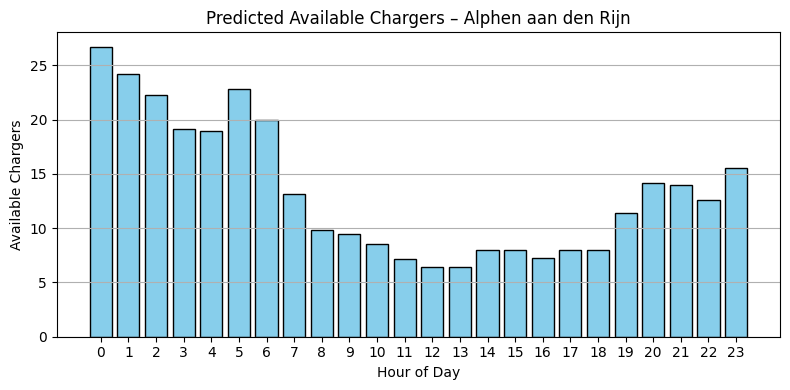

Saved CSV: Alphen_aan_den_Rijn_availability.csv

=== Katwijk ===
Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}
Performance: MAE=2.71, RMSE=11.88, R2=0.69


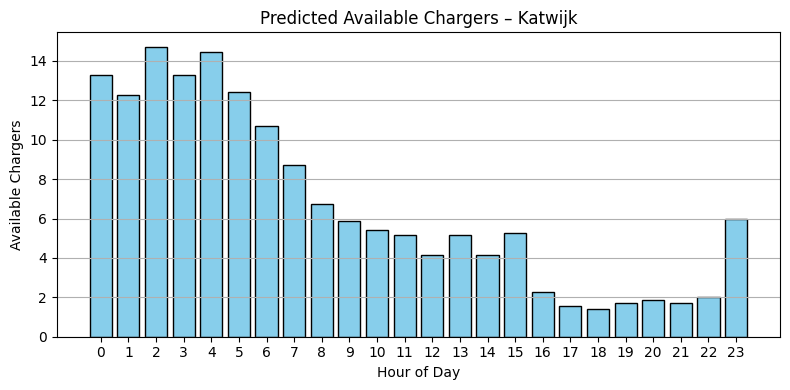

Saved CSV: Katwijk_availability.csv

=== Krimpen aan den IJssel ===
Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}
Performance: MAE=3.48, RMSE=21.73, R2=0.73


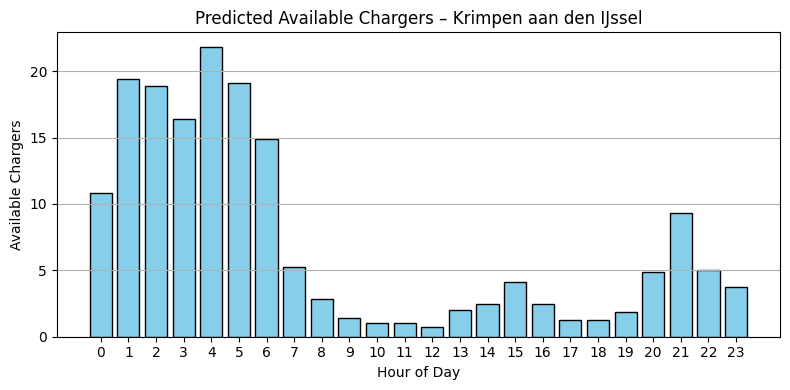

Saved CSV: Krimpen_aan_den_IJssel_availability.csv

=== Leiden ===
Best params: {'alpha': np.float64(3.058449429580245e-05), 'hidden_layer_sizes': (64,), 'learning_rate_init': np.float64(0.007319987722668248)}
Performance: MAE=1.80, RMSE=5.56, R2=0.81


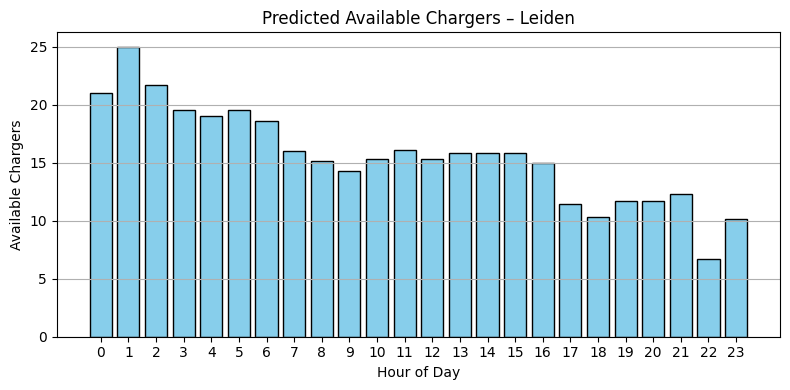

Saved CSV: Leiden_availability.csv

=== Lisse ===
Best params: {'alpha': np.float64(0.0007896910002727694), 'hidden_layer_sizes': (32,), 'learning_rate_init': np.float64(0.0016601864044243652)}
Performance: MAE=4.65, RMSE=37.97, R2=0.36


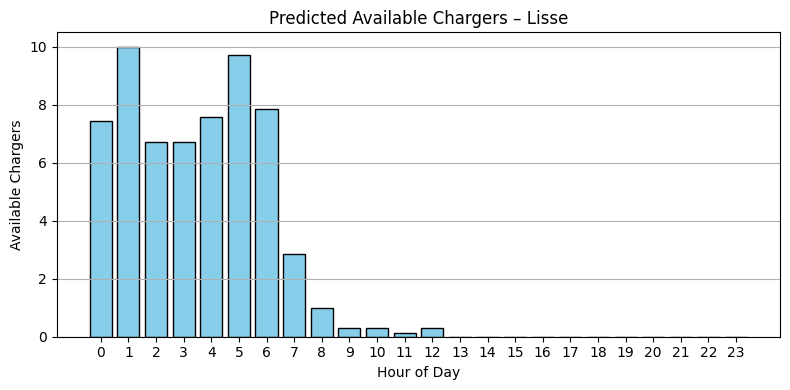

Saved CSV: Lisse_availability.csv

=== Noordwijk ===
Best params: {'alpha': np.float64(0.00016599452033620266), 'hidden_layer_sizes': (64, 32), 'learning_rate_init': np.float64(0.004692488919658672)}
Performance: MAE=1.91, RMSE=7.10, R2=0.87


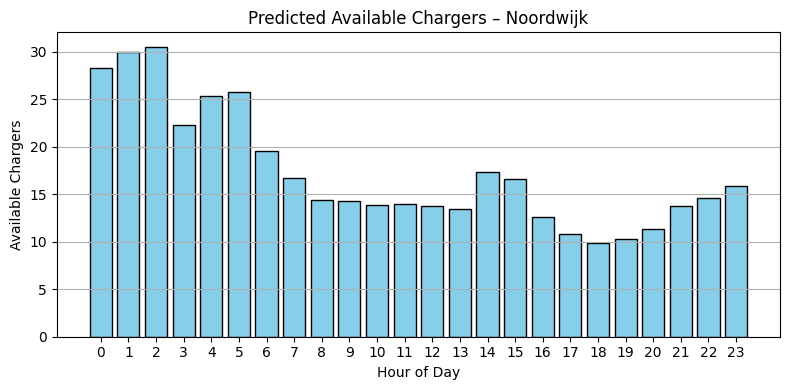

Saved CSV: Noordwijk_availability.csv

=== Summary ===
Alphen aan den Rijn: R2=0.66, MAE=3.77, RMSE=24.10
Katwijk: R2=0.69, MAE=2.71, RMSE=11.88
Krimpen aan den IJssel: R2=0.73, MAE=3.48, RMSE=21.73
Leiden: R2=0.81, MAE=1.80, RMSE=5.56
Lisse: R2=0.36, MAE=4.65, RMSE=37.97
Noordwijk: R2=0.87, MAE=1.91, RMSE=7.10


In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import warnings
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
warnings.filterwarnings('ignore')

# Define each location’s CSV file and total charger count
locations = {
    "Alphen aan den Rijn":      {"file": "Alphen aan den Rijn.csv",      "total": 32},
    "Katwijk":                  {"file": "Katwijk.csv",                  "total": 24},
    "Krimpen aan den IJssel":   {"file": "Krimpen aan den IJssel.csv",   "total": 28},
    "Leiden":                   {"file": "Leiden.csv",                   "total": 30},
    "Lisse":                    {"file": "Lisse.csv",                    "total": 20},
    "Noordwijk":                {"file": "Noordwijk.csv",                "total": 36},
}

results = []

# Loop over locations
for name, info in locations.items():
    print(f"\n=== {name} ===")
    # 1) Load and preprocess
    df = pd.read_csv(info['file'])
    df['chargingStartTime'] = pd.to_datetime(df['chargingStartTime'], errors='coerce')
    df = df.dropna(subset=['chargingStartTime'])
    df['hour'] = df['chargingStartTime'].dt.hour
    df['dayofweek'] = df['chargingStartTime'].dt.dayofweek

    # 2) Compute usage and availability
    usage = df.groupby(['hour','dayofweek'])['evseName'] \
               .nunique().reset_index(name='used_chargers')
    usage['total_chargers'] = info['total']
    usage['available_chargers'] = usage['total_chargers'] - usage['used_chargers']

    # 3) Feature engineering: lagged usage
    for lag in [1,2,3]:
        usage[f'used_lag_{lag}'] = usage['used_chargers'].shift(lag).fillna(method='bfill')
    # Cyclical hour encoding
    usage['hour_sin'] = np.sin(2 * np.pi * usage['hour'] / 24)
    usage['hour_cos'] = np.cos(2 * np.pi * usage['hour'] / 24)
    # One-hot weekday
    dow = pd.get_dummies(usage['dayofweek'], prefix='dow', drop_first=True)
    usage = pd.concat([usage, dow], axis=1)

    # 4) Prepare features and target
    feature_cols = ['total_chargers', 'used_lag_1', 'used_lag_2', 'used_lag_3', 'hour_sin', 'hour_cos'] + list(dow.columns)
    X = usage[feature_cols].values
    y = usage['available_chargers'].values

    # 5) Time-series CV + hyperparameter search for MLP
    tscv = TimeSeriesSplit(n_splits=3)
    param_dist = {
        'hidden_layer_sizes': [(32,), (64,), (64,32), (128,64)],
        'alpha': uniform(1e-5, 1e-3),
        'learning_rate_init': uniform(1e-4, 1e-2)
    }
    mlp = MLPRegressor(max_iter=300, random_state=42)
    search = RandomizedSearchCV(
        mlp, param_dist, n_iter=5, cv=tscv,
        scoring='r2', n_jobs=-1, random_state=42
    )
    # Scale features
    scaler = StandardScaler().fit(X)
    X_s = scaler.transform(X)
    search.fit(X_s, y)
    best = search.best_estimator_
    print(f"Best params: {search.best_params_}")

    # 6) Train best MLP & predict
    best.fit(X_s, y)
    usage['predicted_available'] = best.predict(X_s)

    # Clamp negatives and round to int
    usage['predicted_available'] = np.clip(usage['predicted_available'], 0, None)
    usage['predicted_available'] = usage['predicted_available'].round().astype(int)

    # 7) Evaluate
    mae = mean_absolute_error(y, usage['predicted_available'])
    rmse = mean_squared_error(y, usage['predicted_available'])
    r2 = r2_score(y, usage['predicted_available'])
    print(f"Performance: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")
    results.append((name, mae, rmse, r2))

    # 8) Plot inline
    avg_pred = usage.groupby('hour')['predicted_available'] \
                     .mean().reindex(range(24), fill_value=0)
    plt.figure(figsize=(8,4))
    plt.bar(avg_pred.index, avg_pred.values, color='skyblue', edgecolor='k')
    plt.title(f"Predicted Available Chargers – {name}")
    plt.xlabel('Hour of Day')
    plt.ylabel('Available Chargers')
    plt.xticks(range(24))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # 9) Save CSV
    out_csv = f"{name.replace(' ','_')}_availability.csv"
    usage[['hour','dayofweek','predicted_available']].to_csv(out_csv, index=False)
    print(f"Saved CSV: {out_csv}")

# 10) Summary
print("\n=== Summary ===")
for name, mae, rmse, r2 in results:
    print(f"{name}: R2={r2:.2f}, MAE={mae:.2f}, RMSE={rmse:.2f}")



# **Charging Advice Engine Version 1**



# **battery capacity busses from Qbuzz : 578 Kwh**

Enter your region/depot name: Katwijk
Current SoC (%)        : 51
Target SoC (%)         : 100
Battery capacity (kWh) : 578
Current hour (0–23)     : 17
hour | price   | sessions | delay(min) | available | label
-----------------------------------------------------------
   0 |   0.096 |       11 |          86 |        13 | PAST
   1 |   0.092 |       25 |          56 |        12 | PAST
   2 |   0.083 |       22 |          52 |        14 | PAST
   3 |   0.091 |       15 |          59 |        13 | PAST
   4 |   0.096 |       16 |          52 |        14 | PAST
   5 |   0.108 |       17 |          45 |        12 | PAST
   6 |   0.121 |       15 |          44 |        10 | PAST
   7 |   0.125 |       18 |          48 |         8 | PAST
   8 |   0.113 |       19 |          50 |         6 | PAST
   9 |   0.093 |       22 |          53 |         5 | PAST
  10 |   0.077 |       28 |          58 |         5 | PAST
  11 |   0.071 |       27 |          55 |         5 | PAST
  12 |   0.070 |    

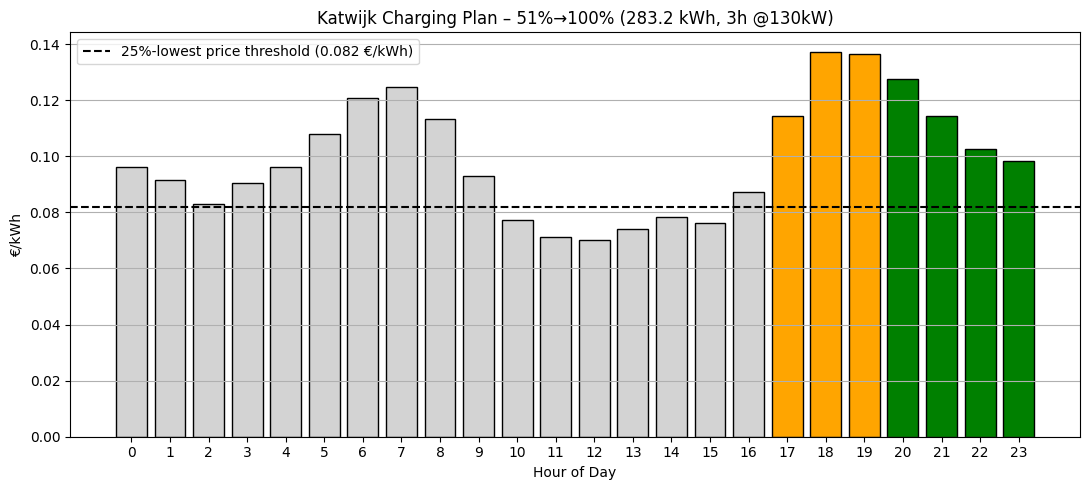

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Simulated inputs (gebruik bij voorkeur input() in de echte versie)
# 🔧 User input
region = input("Enter your region/depot name: ").strip()
soc_now = float(input("Current SoC (%)        : "))
soc_target = float(input("Target SoC (%)         : "))
battery_kwh = float(input("Battery capacity (kWh) : "))
current_hr = int(input("Current hour (0–23)     : "))


# Validatie
if soc_target <= soc_now:
    raise SystemExit("✖ Target SoC must be greater than current SoC.")
if battery_kwh <= 0:
    raise SystemExit("✖ Battery capacity must be greater than 0.")

# 1. CSV’s laden
prices   = pd.read_csv("predicted_prices.csv")
energy   = pd.read_csv("predicted_energy_consumption.csv")
sessions = pd.read_csv("predicted_sessions.csv")
delays   = pd.read_csv("hourly_departure_prediction.csv")
avail_path = f"{region}_availability.csv"
avail = pd.read_csv(avail_path)

# 2. Charging setup
charge_power   = 130.0
kwh_needed     = battery_kwh * (soc_target - soc_now) / 100
minutes_needed = (kwh_needed / charge_power) * 60
hours_needed   = math.ceil(minutes_needed / 60)

# 3. Align voorspellingen
energy["hour"]   = (current_hr + energy.hour_ahead) % 24
sessions["hour"] = (current_hr + sessions.hour_ahead) % 24
delays["hour"]   = delays["hour"] % 24

# 4. Filter juiste locatie en rename kolom
if "predicted_available" not in avail.columns:
    raise ValueError(f"{avail_path} mist kolom 'predicted_available'")
avail["hour"] = avail["hour"] % 24
avail_region = avail.copy()
if "locationUid" in avail_region.columns:
    avail_region = avail_region[avail_region["locationUid"].str.contains(region[:3], case=False)]

# 5. Merge alles samen
df = (prices
      .merge(energy[["hour", "predicted_energy_kwh"]], on="hour")
      .merge(sessions[["hour", "predicted_sessions"]], on="hour")
      .merge(delays[["hour", "predicted_departure_delay_minutes"]], on="hour")
      .merge(avail_region[["hour", "predicted_available"]].groupby("hour").mean().reset_index(), on="hour", how="left")
      .sort_values("hour")
      .reset_index(drop=True))

# 6. Bouw circulaire volgorde vanaf huidige uur
order = list(range(current_hr, 24)) + list(range(0, current_hr))
cand = df.set_index("hour").loc[~df.duplicated("hour")].reindex(order).reset_index()

# 7. Drempels en eligible-flag
cheap_thr   = cand.predicted_price_per_kwh.quantile(0.25)
quiet_thr   = cand.predicted_sessions.median()
lowload_thr = cand.predicted_energy_kwh.quantile(0.40)

cand["eligible"] = (
    (cand.predicted_price_per_kwh <= cheap_thr) &
    (cand.predicted_sessions <= quiet_thr) &
    (cand.predicted_energy_kwh <= lowload_thr) &
    (cand.predicted_departure_delay_minutes >= minutes_needed)
)

# 8. Zoek een continu blok
chosen = []
for i in range(len(cand) - hours_needed + 1):
    block = cand.iloc[i : i + hours_needed]
    if block["eligible"].all():
        chosen = list(block.hour)
        break

# # 8b. Geen blok? Kies goedkoopste losse uren
# if not chosen:
#     cands_sorted = cand.sort_values("predicted_price_per_kwh")
#     chosen = []
#     loaded = 0.0
#     for _, r in cands_sorted.iterrows():
#         if loaded >= kwh_needed:
#             break
#         chosen.append(r.hour)
#         loaded += charge_power
#     chosen = sorted(set(chosen))

# 8b. Geen blok? Kies eerste bruikbare uren vanaf current_hr
if not chosen:
    chosen = []
    loaded = 0.0
    for _, r in cand.iterrows():
        chosen.append(r.hour)
        loaded += charge_power
        if loaded >= kwh_needed:
            break

# 9. Label
df["label"] = "WAIT"
df.loc[df.hour.isin(chosen), "label"] = "LOAD"
df.loc[(df.hour < current_hr) & ~df.hour.isin(chosen), "label"] = "PAST"
if soc_now < 50 and current_hr not in chosen:
    df.loc[df.hour == current_hr, "label"] = "URGENT"

# 10. Print overview
print("hour | price   | sessions | delay(min) | available | label")
print("-----------------------------------------------------------")
for _, r in df.sort_values("hour").iterrows():
    print(f"{int(r.hour):4d} | {r.predicted_price_per_kwh:7.3f} |"
          f" {int(r.predicted_sessions):8d} |"
          f" {int(r.predicted_departure_delay_minutes):11d} |"
          f" {int(r.predicted_available if not pd.isna(r.predicted_available) else -1):9d} |"
          f" {r['label']}")

print(f"\n⚡ Charging planned at: {', '.join(f'{h:02d}:00' for h in sorted(chosen))}")
print(f"   Total kWh covered  : {len(chosen)*charge_power:.1f} (goal: {kwh_needed:.1f})")
print(f"   Duration (est.)    : {hours_needed} hour(s)")

# Plot

import seaborn as sns
import matplotlib.pyplot as plt

color_map = {"LOAD": "orange", "WAIT": "green", "PAST": "lightgrey", "URGENT": "red"}
plt.figure(figsize=(11, 5))
plt.bar(df.hour, df.predicted_price_per_kwh, color=df.label.map(color_map), edgecolor="k")
plt.axhline(cheap_thr, ls="--", color="k", label=f"25%-lowest price threshold ({cheap_thr:.3f} €/kWh)")
plt.title(f"{region} Charging Plan – {soc_now:.0f}%→{soc_target:.0f}% ({kwh_needed:.1f} kWh, {hours_needed}h @{charge_power:.0f}kW)")
plt.xlabel("Hour of Day"); plt.ylabel("€/kWh")
plt.xticks(range(24)); plt.legend(); plt.grid(axis="y")
plt.tight_layout(); plt.show()


# **Charging Advice Engine Version 2**



Enter your region/depot name: Katwijk
Current SoC (%)        : 51
Target SoC (%)         : 100
Battery capacity (kWh) : 578
Current hour (0–23)     : 17
hour | price   | sessions | delay(min) | available | label
-----------------------------------------------------------
   0 |   0.096 |       11 |          86 |        13 | LOAD
   1 |   0.092 |       25 |          56 |        12 | LOAD
   2 |   0.083 |       22 |          52 |        14 | PAST
   3 |   0.091 |       15 |          59 |        13 | PAST
   4 |   0.096 |       16 |          52 |        14 | PAST
   5 |   0.108 |       17 |          45 |        12 | PAST
   6 |   0.121 |       15 |          44 |        10 | PAST
   7 |   0.125 |       18 |          48 |         8 | PAST
   8 |   0.113 |       19 |          50 |         6 | PAST
   9 |   0.093 |       22 |          53 |         5 | PAST
  10 |   0.077 |       28 |          58 |         5 | PAST
  11 |   0.071 |       27 |          55 |         5 | PAST
  12 |   0.070 |    

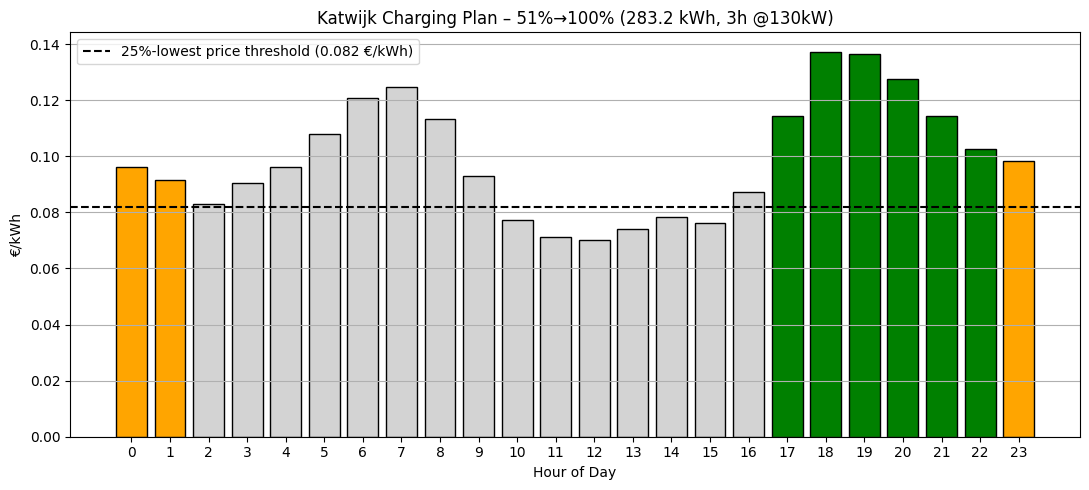

In [14]:
1import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Simulated inputs (gebruik bij voorkeur input() in de echte versie)
region = input("Enter your region/depot name: ").strip()
soc_now = float(input("Current SoC (%)        : "))
soc_target = float(input("Target SoC (%)         : "))
battery_kwh = float(input("Battery capacity (kWh) : "))
current_hr = int(input("Current hour (0–23)     : "))

# Validatie
if soc_target <= soc_now:
    raise SystemExit("✖ Target SoC must be greater than current SoC.")
if battery_kwh <= 0:
    raise SystemExit("✖ Battery capacity must be greater than 0.")

# 1. CSV’s laden
prices   = pd.read_csv("predicted_prices.csv")
energy   = pd.read_csv("predicted_energy_consumption.csv")
sessions = pd.read_csv("predicted_sessions.csv")
delays   = pd.read_csv("hourly_departure_prediction.csv")
avail_path = f"{region}_availability.csv"
avail = pd.read_csv(avail_path)

# 2. Charging setup
charge_power   = 130.0
kwh_needed     = battery_kwh * (soc_target - soc_now) / 100
minutes_needed = (kwh_needed / charge_power) * 60
hours_needed   = math.ceil(minutes_needed / 60)

# 3. Align voorspellingen
energy["hour"]   = (current_hr + energy.hour_ahead) % 24
sessions["hour"] = (current_hr + sessions.hour_ahead) % 24
delays["hour"]   = delays["hour"] % 24

# 4. Filter juiste locatie en rename kolom
if "predicted_available" not in avail.columns:
    raise ValueError(f"{avail_path} mist kolom 'predicted_available'")
avail["hour"] = avail["hour"] % 24
avail_region = avail.copy()
if "locationUid" in avail_region.columns:
    avail_region = avail_region[avail_region["locationUid"].str.contains(region[:3], case=False)]

# 5. Merge alles samen
df = (prices
      .merge(energy[["hour", "predicted_energy_kwh"]], on="hour")
      .merge(sessions[["hour", "predicted_sessions"]], on="hour")
      .merge(delays[["hour", "predicted_departure_delay_minutes"]], on="hour")
      .merge(avail_region[["hour", "predicted_available"]].groupby("hour").mean().reset_index(), on="hour", how="left")
      .sort_values("hour")
      .reset_index(drop=True))

# 6. Zoek eerste mogelijke goedkope blok in hele dag
cheap_thr   = df.predicted_price_per_kwh.quantile(0.25)
quiet_thr   = df.predicted_sessions.median()
lowload_thr = df.predicted_energy_kwh.quantile(0.40)

# Eligible check over hele dag
full_day = df.copy()
full_day["eligible"] = (
    (full_day.predicted_price_per_kwh <= cheap_thr) &
    (full_day.predicted_sessions <= quiet_thr) &
    (full_day.predicted_energy_kwh <= lowload_thr) &
    (full_day.predicted_departure_delay_minutes >= minutes_needed)
)

for i in range(24 - hours_needed + 1):
    block = full_day.iloc[i : i + hours_needed]
    if block["eligible"].all():
        current_hr = int(block.hour.iloc[0])
        break

# 7. Bouw circulaire volgorde vanaf nieuwe current_hr
order = list(range(current_hr, 24)) + list(range(0, current_hr))
cand = df.set_index("hour").loc[~df.duplicated("hour")].reindex(order).reset_index()

# 8. Eligible opnieuw op cand
cand["eligible"] = (
    (cand.predicted_price_per_kwh <= cheap_thr) &
    (cand.predicted_sessions <= quiet_thr) &
    (cand.predicted_energy_kwh <= lowload_thr) &
    (cand.predicted_departure_delay_minutes >= minutes_needed)
)

# 8. Zoek goedkoopste aaneengesloten blok dat NA current_hr begint (of bij gelijkwaardige prijs)
chosen = []
cand["cost"] = cand.predicted_price_per_kwh * charge_power
min_total_cost = float("inf")

for i in range(len(cand) - hours_needed + 1):
    block = cand.iloc[i : i + hours_needed]
    start_hr = block.iloc[0].hour
    if start_hr < current_hr:
        continue  # sla blokken over die in het verleden starten

    if (block["cost"].sum() < min_total_cost):
        chosen = list(block.hour)
        min_total_cost = block["cost"].sum()


# 10. Label alle uren
df["label"] = "WAIT"
df.loc[df.hour.isin(chosen), "label"] = "LOAD"
df.loc[(df.hour < current_hr) & ~df.hour.isin(chosen), "label"] = "PAST"
if soc_now < 50 and current_hr not in chosen:
    df.loc[df.hour == current_hr, "label"] = "URGENT"

# 11. Print overzicht
print("hour | price   | sessions | delay(min) | available | label")
print("-----------------------------------------------------------")
for _, r in df.sort_values("hour").iterrows():
    print(f"{int(r.hour):4d} | {r.predicted_price_per_kwh:7.3f} |"
          f" {int(r.predicted_sessions):8d} |"
          f" {int(r.predicted_departure_delay_minutes):11d} |"
          f" {int(r.predicted_available if not pd.isna(r.predicted_available) else -1):9d} |"
          f" {r['label']}")

print(f"\n⚡ Charging planned at: {', '.join(f'{h:02d}:00' for h in sorted(chosen))}")
print(f"   Total kWh covered  : {len(chosen)*charge_power:.1f} (goal: {kwh_needed:.1f})")
print(f"   Duration (est.)    : {hours_needed} hour(s)")

# 12. Plot
color_map = {"LOAD": "orange", "WAIT": "green", "PAST": "lightgrey", "URGENT": "red"}
plt.figure(figsize=(11, 5))
plt.bar(df.hour, df.predicted_price_per_kwh, color=df.label.map(color_map), edgecolor="k")
plt.axhline(cheap_thr, ls="--", color="k", label=f"25%-lowest price threshold ({cheap_thr:.3f} €/kWh)")
plt.title(f"{region} Charging Plan – {soc_now:.0f}%→{soc_target:.0f}% ({kwh_needed:.1f} kWh, {hours_needed}h @{charge_power:.0f}kW)")
plt.xlabel("Hour of Day"); plt.ylabel("€/kWh")
plt.xticks(range(24)); plt.legend(); plt.grid(axis="y")
plt.tight_layout(); plt.show()
